## Dot density python script

Adapted from: <a href='https://github.com/agaidus/census_data_extraction/blob/master/census_mapper.py'> https://github.com/agaidus/census_data_extraction/blob/master/census_mapper.py</a><br>
Tutorial: <a href='http://andrewgaidus.com/Dot_Density_County_Maps/'>http://andrewgaidus.com/Dot_Density_County_Maps/</a>

In [1]:
# Import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from cenpy import products
from shapely.geometry import Polygon
from numpy.random import RandomState, uniform
from shapely.geometry import Point

# Define product
acs = products.ACS(2019)
census = products.Decennial2010

#### Functions to generate random points:

In [7]:
def gen_random_points_poly(poly, num_points, seed = None):
    """
    Returns a list of N randomly generated points within a polygon. 
    """
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i=0
    while len(points) < num_points:
        s=RandomState(seed+i) if seed else RandomState(seed)
        random_point = Point([s.uniform(min_x, max_x), s.uniform(min_y, max_y)])
        if random_point.within(poly):
            points.append(random_point)
        i+=1
    return points

def gen_points_in_gdf_polys(geometry, values, points_per_value = None, seed = None):
    """
    Take a GeoSeries of Polygons along with a Series of values and returns randomly generated points within
    these polygons. Optionally takes a "points_per_value" integer which indicates the number of points that 
    should be generated for each 1 value.
    """
    if points_per_value:
        new_values = (values/points_per_value).astype(int)
    else:
        new_values = values
    new_values = new_values[new_values>0]
    g = gpd.GeoDataFrame(data = {'vals':new_values}, geometry = geometry)
    
    a = g.apply(lambda row: tuple(gen_random_points_poly(row['geometry'], row['vals'], seed)),1)
    b = gpd.GeoSeries(a.apply(pd.Series).stack(), crs = geometry.crs)
    b.name='geometry'
    return b

#### Dot density function for one county

In [52]:
#base
def gen_count_dot_density_map(county, pts_per_person = 300, 
                              epsg = 2163, seed=10,
                              dot_transparency=0.4, figsize=(12,12), 
                              ax=None, legend=True):
    """
    Wraps previous functions and generates population dot density maps for a specified county by race
    
    """
    #read in fips to county name relationship file
    county_fips = products.ACS(2019).from_county(county, level='tract',
                                        variables=["B01001A_001E", 'B01001B_001E', 'B01001C_001E', 'B01001D_001E','B01001E_001E', 'B01001F_001E'])
    
    
    #Calculate county boundaries as the union of block groups 
    union = gpd.GeoSeries(county_fips['geometry'].unary_union)
    
    #if axes object is specified, plot to this axis, otherwise create a new one
    if ax:
        union.plot(color='white', figsize=figsize, ax=ax)
    else:
        ax = union.plot(color='white', figsize=figsize)
   
    #set aspect equal and add title if specified
    ax.set(aspect='equal', xticks=[], yticks=[])
    #set title as county name
    ax.set_title(county, size=15)
    
    #annotate the dot per person ratio
    ax.annotate("1 dot = {} people".format(pts_per_person), 
                xy=(.5, .97), xycoords='axes fraction', horizontalalignment='center',
                fontsize = 12)
        
    #loop each race category and generate points for each within each block group 
    list_of_point_categories=[]
    for field in ["B01001A_001E", 'B01001B_001E', 'B01001C_001E', 'B01001D_001E','B01001E_001E', 'B01001F_001E']:           
        ps=gpd.GeoDataFrame(gen_points_in_gdf_polys(geometry = county_fips['geometry'], values=county_fips[field],
                             points_per_value = pts_per_person, seed=seed))
        ps['field']=field
        list_of_point_categories.append(ps)
    all_points=gpd.GeoDataFrame(pd.concat(list_of_point_categories))
    all_points.plot(ax=ax, markersize=2, alpha=dot_transparency, 
              column='field', categorical=True, legend=legend)

    return ax

C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the

<AxesSubplot:title={'center':'Wayne County, MI'}>

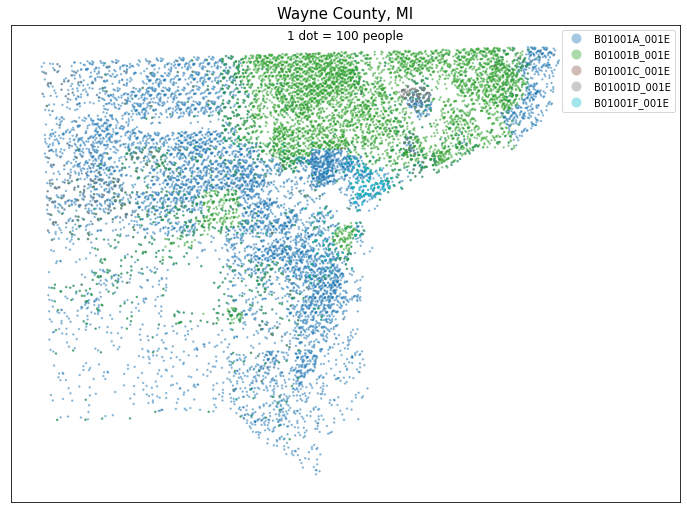

In [54]:
gen_count_dot_density_map('Wayne County, MI', pts_per_person = 100)

#### Function to load and append data from several counties into one geodataframe

In [8]:
def get_counties_data(counties = ['Wayne County, MI', 'Macomb County, MI', 'Oakland County, MI'], pts_per_person = 100, 
                              epsg = 2163):
    detroit = []
    for county in counties:
        county_data = products.ACS(2019).from_county(county, level='tract',
                    variables=["B01001A_001E", 'B01001B_001E', 'B01001C_001E', 'B01001D_001E','B01001E_001E', 'B01001F_001E'])
        print("Processing " + county + "...")
        detroit.append(county_data)
    detroit_df = pd.concat(detroit)
    detroit_df = detroit_df.reset_index()
    return detroit_df


#### Function to generate a dot density map for several counties at a time.

In [17]:
#iterative several counties

def gen_count_dot_density_map_several(counties=['Wayne County, MI', 'Macomb County, MI', 'Oakland County, MI'], pts_per_person = 100, 
                              epsg = 2163, seed=10,
                              dot_transparency=0.4, figsize=(12,12), 
                              ax=None, legend=True):
    """
    Wraps previous functions and generates population dot density maps for a specified county by race
    
    """
    detroit = get_counties_data(counties, pts_per_person, epsg)
    
    #Calculate boundaries as the union of block groups 
    union = gpd.GeoSeries(detroit['geometry'].unary_union)
    
    #if axes object is specified, plot to this axis, otherwise create a new one
    if ax:
        union.plot(color='white', figsize=figsize, ax=ax)
    else:
        ax = union.plot(color='white', figsize=figsize)
        
    title = "Wayne, Macomb, and Oakland counties"
   
    #set aspect equal and add title if specified
    ax.set(aspect='equal', xticks=[], yticks=[])
    #set title as county name
    ax.set_title(title, size=15)
    
    #annotate the dot per person ratio
    ax.annotate("1 dot = {} people".format(pts_per_person), 
                xy=(.5, .97), xycoords='axes fraction', horizontalalignment='center',
                fontsize = 12)
        
    #loop each race category and generate points for each within each block group 
    list_of_point_categories=[]
    #Racial_Labels = ["White", "Black or African American", "American Indian or Alaskan native", "Asian", "Native Hawaiian or Pacific Islander", "Other"]
    for field in ["B01001A_001E", 'B01001B_001E', 'B01001C_001E', 'B01001D_001E','B01001E_001E', 'B01001F_001E']:           
        ps=gpd.GeoDataFrame(gen_points_in_gdf_polys(geometry = detroit['geometry'], values=detroit[field],
                             points_per_value = pts_per_person, seed=seed))
        ps['field']=field
        list_of_point_categories.append(ps)
    all_points=gpd.GeoDataFrame(pd.concat(list_of_point_categories))
    all_points.plot(ax=ax, markersize=2, alpha=dot_transparency, 
                    column='field', categorical=True, legend=legend)

    return all_points

C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the

Processing Wayne County, MI...


C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the

Processing Macomb County, MI...


C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the

Processing Oakland County, MI...


C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecatio

IndexError: index 6 is out of bounds for axis 0 with size 6

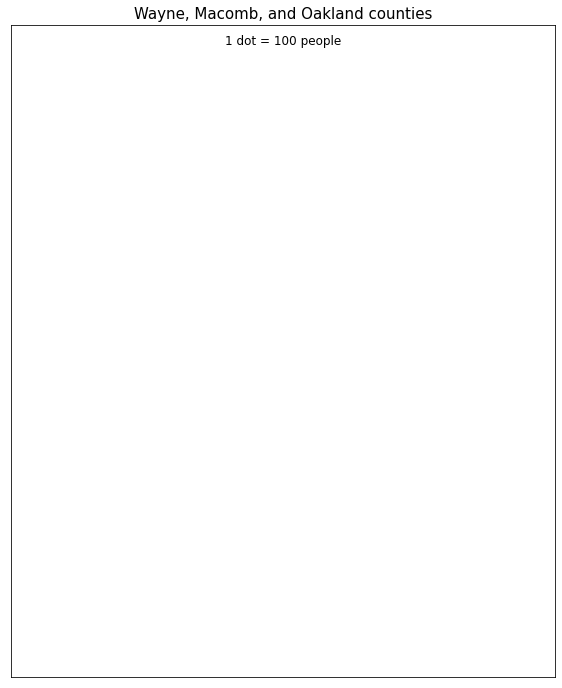

In [18]:
detroit_area = gen_count_dot_density_map_several(['Wayne County, MI', 'Macomb County, MI', 'Oakland County, MI'], pts_per_person=100)

detroit_area

##### Add bool fields based on racial categories

In [16]:
detroit_area['white'] = detroit_area['field'] == 'B01001A_001E'
detroit_area['black'] = detroit_area['field'] == 'B01001B_001E'
detroit_area['AI_AK'] = detroit_area['field'] == 'B01001C_001E'
detroit_area['asian'] = detroit_area['field'] == 'B01001D_001E'
detroit_area['NH_PI'] = detroit_area['field'] == 'B01001E_001E'
detroit_area['other'] = detroit_area['field'] == 'B01001F_001E'

#### Export to shapefile

In [15]:
detroit_area.to_file('dot_map.shp')